In [1]:
import os, sys
currentFolder = os.path.abspath('')
try:
    sys.path.remove(str(currentFolder))
except ValueError: # Already removed
    pass

projectFolder = 'C:/Users/abjawad/Documents/GitHub/local-attention-model'
sys.path.append(str(projectFolder))
os.chdir(projectFolder)
print( f"current working dir{os.getcwd()}")

current working dirC:\Users\abjawad\Documents\GitHub\local-attention-model


In [2]:

import torch
from  torch.utils.data import DataLoader
import torch.nn as nn
from models.builder import EncoderDecoder as segmodel
from dataloader.cfg_defaults import get_cfg_defaults
from utils.lr_policy import WarmUpPolyLR
from utils.init_func import init_weight, group_weight
from config_cityscapes import *
import yaml
import os
from dataloader.cityscapes_dataloader import CityscapesDataset

c:\Users\abjawad\.conda\envs\pt_cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\abjawad\.conda\envs\pt_cuda\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
config_path = 'C:/Users/abjawad/Documents/GitHub/local-attention-model/dataloader/cityscapes_rgbd_config.yaml'
# with open(config_path) as info:
#     info_dict = yaml.load(info, Loader=yaml.FullLoader)
cfg = get_cfg_defaults()
cfg.merge_from_file(config_path)
cfg.freeze()

data_mean = [0.291,  0.329,  0.291]
data_std = [0.190,  0.190,  0.185]

In [4]:
cityscapes_train = CityscapesDataset(cfg, split='train')
train_loader = DataLoader(cityscapes_train, batch_size=4, shuffle=True, num_workers=4, drop_last=True)
print(f'total train: {len(cityscapes_train)} t_iteration:{len(train_loader)}')

cityscapes_val = CityscapesDataset(cfg, split='val')
val_loader = DataLoader(cityscapes_val, batch_size=1, shuffle=False, num_workers=4)
print(f'total val: {len(cityscapes_val)} v_iteration:{len(val_loader)}')

Using RGB input
Using RGB input
Found 2975 train images
total train: 2975 t_iteration:743
Using RGB input
Using RGB input
Found 500 val images
total val: 500 v_iteration:500


#### Visualiz Image 

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


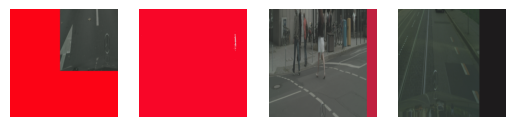

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Access the first batch from the DataLoader
for batch in train_loader:
    images = batch['image']

    # Process each image in the batch
    for i in range(images.shape[0]):
        img = images[i].numpy().transpose((1, 2, 0))
        img *= data_std
        img += data_mean

        print(img.shape)
        # Plot the image in the subplot
        plt.subplot(1, 4, i + 1)  # 1 row, 4 columns, i+1 is the current subplot
        plt.imshow(img)
        plt.axis('off')

    plt.show()

    # Break the loop after the first batch
    break


In [6]:
# write some error to stop notebook at this point
assert False, "Stop notebook here"

AssertionError: Stop notebook here

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=config.background)
BatchNorm2d = nn.BatchNorm2d
model=segmodel(cfg=config, criterion=criterion, norm_layer=BatchNorm2d)

params_list = []
params_list = group_weight(params_list, model, BatchNorm2d, config.lr)        
optimizer = torch.optim.AdamW(params_list, lr=config.lr, betas=(0.9, 0.999), weight_decay=config.weight_decay)
total_iteration = config.nepochs * config.niters_per_epoch
lr_policy = WarmUpPolyLR(config.lr, config.lr_power, total_iteration, config.niters_per_epoch * config.warm_up_epoch)
print(f'lr_policy:{vars(lr_policy)}')



for epoch in range(1, 2):
    model.train()
    optimizer.zero_grad()
    sum_loss = 0
    m_iou_batches = 0
    for idx, sample in enumerate(train_loader):
        imgs = sample['image']
        gts = sample['label']
        imgs = imgs.to(f'cuda:{model.device_ids[0]}', non_blocking=True)
        gts = gts.to(f'cuda:{model.device_ids[0]}', non_blocking=True)  

        print('images shape', imgs.shape)
        print('gts shape', gts.shape)
        # loss, out = model(imgs, gts)
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        # sum_loss += loss
        # print(f'epoch:{epoch} iteration:{idx} loss:{loss}')
        break
    # print(f'epoch:{epoch}')

In [ ]:
import numpy as np

In [ ]:
def get_crop_bbox(img, crop_size):
    """Randomly get a crop bounding box."""
    margin_h = max(img.shape[0] - crop_size[0], 0)
    margin_w = max(img.shape[1] - crop_size[1], 0)
    offset_h = np.random.randint(0, margin_h + 1)
    offset_w = np.random.randint(0, margin_w + 1)
    crop_y1, crop_y2 = offset_h, offset_h + crop_size[0]
    crop_x1, crop_x2 = offset_w, offset_w + crop_size[1]

    return crop_y1, crop_y2, crop_x1, crop_x2

In [ ]:
# create a random image 1294, 2588
img = np.random.rand(1294, 2588, 3)
print('img shape', img.shape)
crop_size = (512, 1024)

crop_y1, crop_y2, crop_x1, crop_x2 = get_crop_bbox(img, crop_size)
print('crop_y1', crop_y1)
print('crop_y2', crop_y2)
print('crop_x1', crop_x1)
print('crop_x2', crop_x2)

# crop the image
img_crop = img[crop_y1:crop_y2, crop_x1:crop_x2, :]
print('img_crop shape', img_crop.shape)